In [1]:
# Step 1: Import Libraries
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


In [2]:
# Step 2: Load Dataset
# =============================
df = pd.read_csv("healthcare_patients.csv")
print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print(df.head())


✅ Dataset loaded successfully!
Shape: (60, 9)
   PatientID  Fever  Cough  Headache  Fatigue  ShortnessOfBreath  Diabetes  \
0          1      1      1         1        0                  0         0   
1          2      1      0         1        1                  0         1   
2          3      0      1         0        1                  0         0   
3          4      1      1         1        1                  1         0   
4          5      0      0         0        0                  0         1   

   Hypertension                       Treatment  
0             0         Paracetamol,Cough Syrup  
1             0             Paracetamol,Insulin  
2             0           Cough Syrup,Vitamin C  
3             1  Paracetamol,Oxygen,Antibiotics  
4             1      Insulin,Blood Pressure Med  


E:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

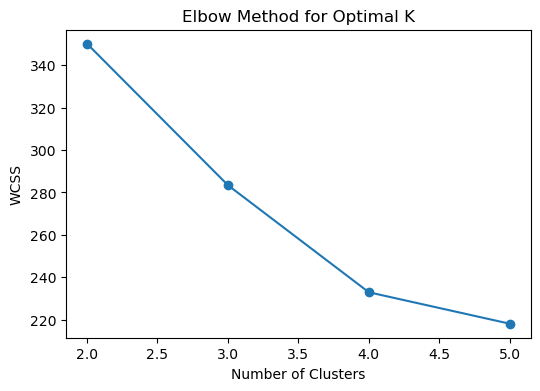


✅ Cluster distribution:
Cluster
0    22
1    20
2    18
Name: count, dtype: int64


E:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [3]:
# Step 3: Clustering Patients by Symptoms
# =============================
symptom_cols = ['Fever', 'Cough', 'Headache', 'Fatigue', 'ShortnessOfBreath', 'Diabetes', 'Hypertension']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[symptom_cols])

# Determine optimal K using Elbow method
wcss = []
K = range(2,6)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

# Apply K-Means with K=3
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)
print("\n✅ Cluster distribution:")
print(df['Cluster'].value_counts())



In [4]:

# Step 4: Visualize Clusters
# =============================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette="Set2", s=80)
plt.title("Patient Clusters (based on Symptoms)")
plt.show()

In [5]:
# Step 5: Association Rule Mining for Treatments
# =============================
transactions = df['Treatment'].apply(lambda x: x.split(',')).tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori
frequent_items = apriori(df_encoded, min_support=0.1, use_colnames=True)
frequent_items = frequent_items.sort_values(by="support", ascending=False)
print("\n✅ Frequent Treatment Combinations:")
print(frequent_items.head(10))

# Generate Rules
if not frequent_items.empty:
    rules = association_rules(frequent_items, metric="confidence", min_threshold=0.3)
    rules = rules.sort_values(by="lift", ascending=False)
    print("\n✅ Association Rules Generated:")
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
else:
    print("⚠️ No frequent itemsets found. Try lowering min_support.")



✅ Frequent Treatment Combinations:
     support                    itemsets
5   0.566667               (Paracetamol)
4   0.516667                    (Oxygen)
3   0.383333                   (Insulin)
2   0.250000               (Cough Syrup)
12  0.233333       (Oxygen, Paracetamol)
0   0.216667               (Antibiotics)
8   0.216667  (Antibiotics, Paracetamol)
11  0.216667      (Insulin, Paracetamol)
10  0.216667           (Oxygen, Insulin)
9   0.133333       (Cough Syrup, Oxygen)

✅ Association Rules Generated:
                   antecedents                 consequents   support  \
12       (Oxygen, Paracetamol)               (Antibiotics)  0.133333   
13               (Antibiotics)       (Oxygen, Paracetamol)  0.133333   
19               (Antibiotics)      (Insulin, Paracetamol)  0.116667   
18      (Insulin, Paracetamol)               (Antibiotics)  0.116667   
3                (Paracetamol)               (Antibiotics)  0.216667   
2                (Antibiotics)               (Par

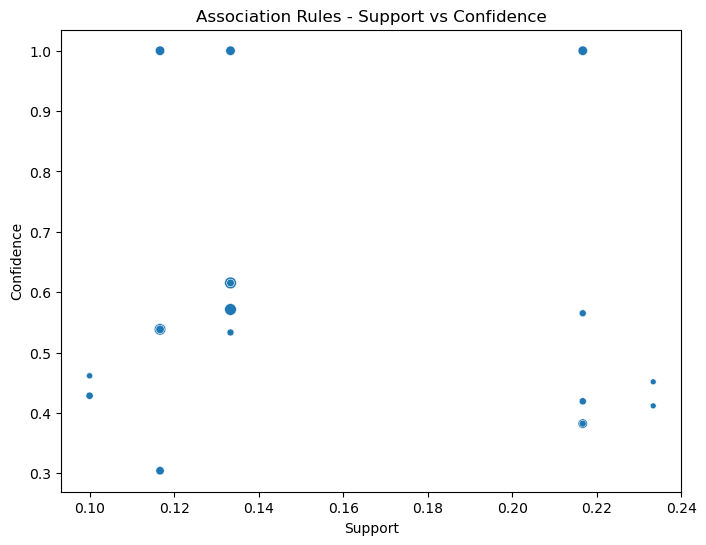

In [6]:
# Step 6: Visualize Association Rules
# =============================
if not frequent_items.empty and not rules.empty:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x="support", y="confidence", size="lift", data=rules, legend=False)
    plt.title("Association Rules - Support vs Confidence")
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.show()

In [7]:
# Step 7: Top 5 Rules Summary
# =============================
if not rules.empty:
    print("\n🧠 Top 5 Treatment Association Rules:")
    for i, row in rules.head(5).iterrows():
        print(f"{set(row['antecedents'])} → {set(row['consequents'])} "
              f"(support={row['support']:.2f}, confidence={row['confidence']:.2f}, lift={row['lift']:.2f})")


🧠 Top 5 Treatment Association Rules:
{'Oxygen', 'Paracetamol'} → {'Antibiotics'} (support=0.13, confidence=0.57, lift=2.64)
{'Antibiotics'} → {'Oxygen', 'Paracetamol'} (support=0.13, confidence=0.62, lift=2.64)
{'Antibiotics'} → {'Insulin', 'Paracetamol'} (support=0.12, confidence=0.54, lift=2.49)
{'Insulin', 'Paracetamol'} → {'Antibiotics'} (support=0.12, confidence=0.54, lift=2.49)
{'Paracetamol'} → {'Antibiotics'} (support=0.22, confidence=0.38, lift=1.76)
